In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import datetime
import warnings
import pickle
%matplotlib inline
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

### Residuals TS

In [2]:
#Load residuals and set index as datetime
residuals_raw = pd.read_csv('Residuals_from_random_forest.csv', encoding='latin1', index_col='date_hour')
residuals_raw.index = residuals_raw.index.to_datetime()
residuals = residuals_raw.asfreq('H')


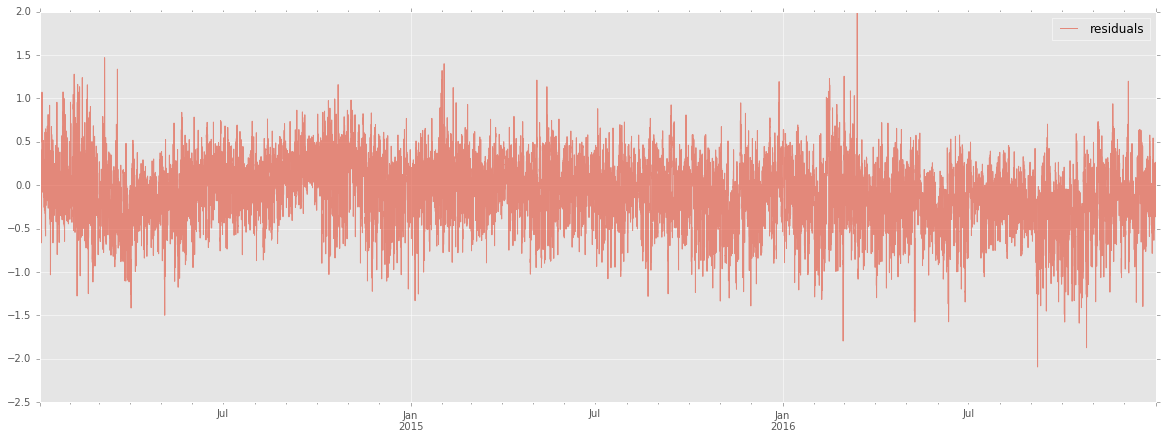

In [3]:
#Plot residual TS
residuals.plot(figsize=(20,7), alpha=0.6);

### Dick-Fuller test on stationarity

In [4]:
from statsmodels.tsa.stattools import adfuller

In [5]:
def perform_stationarity_test(timeseries):
    print('Results of the Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutpout = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags used',
                                             'Number of observation used'])
    for key, value in dftest[4].items():
        dfoutpout['Critical value (%s)'%key] = value
    print(dfoutpout)

In [6]:
perform_stationarity_test(residuals['residuals'])

Results of the Dickey-Fuller Test:
Test Statistic               -1.443782e+01
p-value                       7.444821e-27
#Lags used                    4.900000e+01
Number of observation used    2.623000e+04
Critical value (5%)          -2.861650e+00
Critical value (1%)          -3.430599e+00
Critical value (10%)         -2.566829e+00
dtype: float64


### ACF and PACF

In [7]:
from statsmodels.tsa.stattools import acf, pacf

In [8]:
def computer_acf_pacf(timeseries, acf_lags, pacf_lags):
    lag_acf = acf(timeseries, nlags=acf_lags)
    lag_acf_df = pd.DataFrame(lag_acf, columns=['ACF'])
    lag_acf_df.index.name = 'Hour'
    
    lag_pacf = pacf(timeseries.dropna(), nlags=pacf_lags)
    lag_pacf_df = pd.DataFrame(lag_pacf, columns=['PACF'])
    lag_pacf_df.index.name = 'Hour'
    
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(20,15))
    lag_acf_df.iloc[:100].plot(kind='bar', ax=ax0)
    ax0.axhline(y=-1.96/np.sqrt(len(lag_acf)), linestyle='--', color='blue')
    ax0.axhline(y=+1.96/np.sqrt(len(lag_acf)), linestyle='--', color='blue')
    lag_pacf_df.iloc[:100].plot(kind='bar', ax=ax1);
    ax1.axhline(y=-1.96/np.sqrt(len(lag_pacf)), linestyle='--', color='blue')
    ax1.axhline(y=+1.96/np.sqrt(len(lag_pacf)), linestyle='--', color='blue')

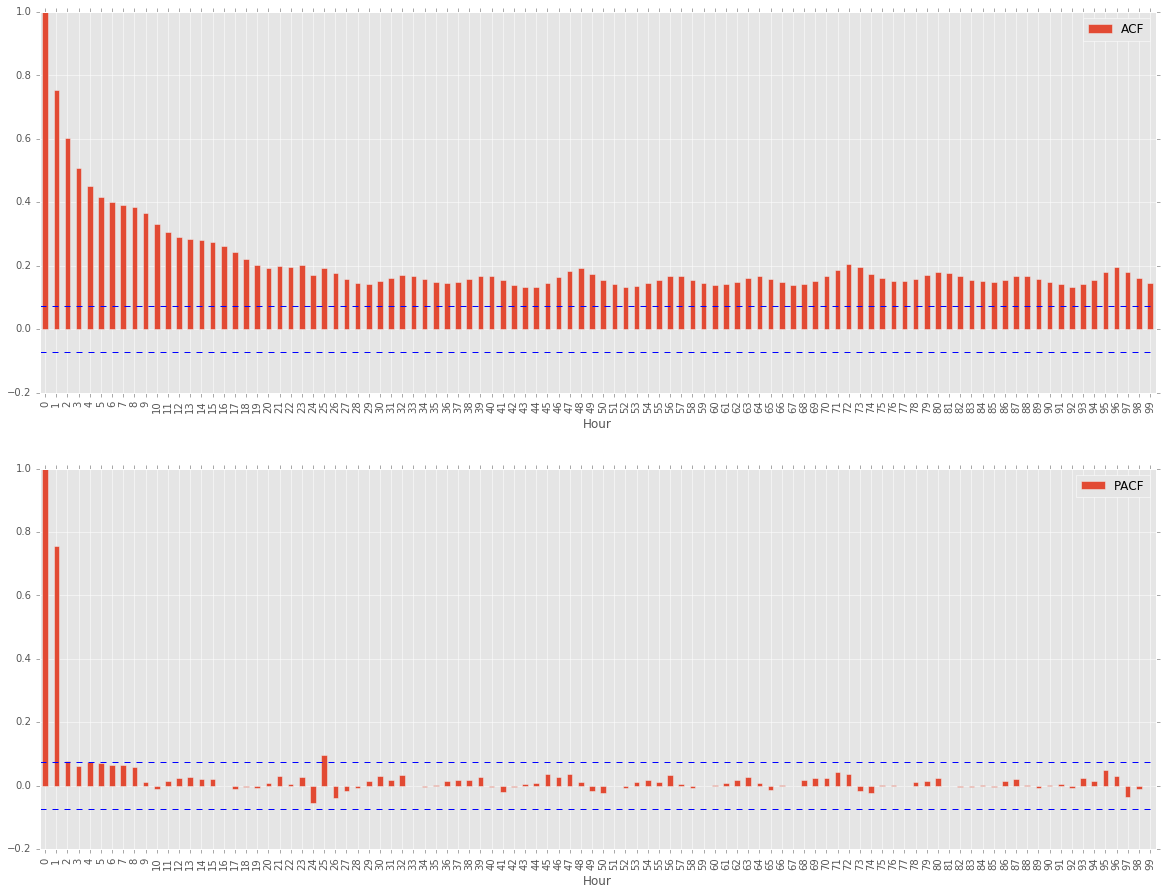

In [9]:
#ACF and PACF suggest an ARMA model with p = 2 or 3 and q = 0
computer_acf_pacf(residuals['residuals'], 720, 720)

### ARIMA model, p=3; q=0

In [10]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [11]:
def compute_ARIMA_model(timeseries, p, d, q):
    model = ARIMA(timeseries, order=(p,d,q))
    results = model.fit(disp=-1, maxiter=500, trend='nc')
    return results

In [12]:
def check_cv_fold(timeseries, train_index, test_index, p,d,q):
    model = compute_ARIMA_model(timeseries.iloc[train_index], p, d, q)
    y_pred = np.reshape(model.forecast(steps=24)[0], (24,))
    y_true = timeseries.iloc[test_index].values[:24]
    error = mean_squared_error(y_true, y_pred)
    train_residuals = np.mean(model.resid**2)
    print('train length: %d, train MSE %.4f, test MSE %.4f' %(len(train_index), train_residuals, error))
    return train_residuals, error

In [13]:
tscv = TimeSeriesSplit(n_splits=5)
train_error = list()
test_error = list()
for train_index, test_index in tscv.split(residuals['residuals'].values):
    tr_error, ts_error =check_cv_fold(residuals, train_index, test_index, 3,0,0)
    train_error.append(tr_error)
    test_error.append(ts_error)
print('Train MSE: %.4f, Test MSE: %.4f' %(np.mean(train_error), np.mean(test_error)))

train length: 4380, train MSE 0.0650, test MSE 0.0436
train length: 8760, train MSE 0.0558, test MSE 0.1107
train length: 13140, train MSE 0.0535, test MSE 0.1125
train length: 17520, train MSE 0.0519, test MSE 0.1139
train length: 21900, train MSE 0.0534, test MSE 0.0409
Train MSE: 0.0559, Test MSE: 0.0843


In [14]:
fitted_model = compute_ARIMA_model(residuals, 3, 0, 0)

In [15]:
print(fitted_model.summary2())

                           Results: ARMA
Model:              ARMA             BIC:                 -2518.8409
Dependent Variable: residuals        Log-Likelihood:      1279.8    
Date:               2017-02-13 20:44 Scale:               1.0000    
No. Observations:   26280            Method:              css-mle   
Df Model:           3                Sample:              01-02-2014
Df Residuals:       26277                                 12-31-2016
Converged:          1.0000           S.D. of innovations: 0.230     
AIC:                -2551.5471       HQIC:                -2540.986 
---------------------------------------------------------------------
                   Coef.   Std.Err.     t      P>|t|   [0.025  0.975]
---------------------------------------------------------------------
ar.L1.residuals    0.6966    0.0062  113.1986  0.0000  0.6845  0.7086
ar.L2.residuals    0.0372    0.0075    4.9633  0.0000  0.0225  0.0519
ar.L3.residuals    0.0693    0.0062   11.2678  0.0000  0.

In [21]:
#Export armaparams into a pickle
ar_parameters = fitted_model.arparams

with open('ar_parameters_p', 'wb') as f:
    pickle.dump(ar_parameters, f)